## Load the data

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
import os
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data/datasets')
data_name = 'oqmd.csv'
data_path = os.path.join(data_dir, data_name)
df = pd.read_csv(data_path)

In [3]:
print('-'*25 + 'Data Info' + '-'*25)
print(df.head())
print('-'*25 + 'Data Info' + '-'*25)

-------------------------Data Info-------------------------
    formula  energy_per_atom  formation_energy_per_atom  band_gap  \
0  ZrZnNiMo        -6.399036                   0.157939       0.0   
1   DySc2Ir        -6.795189                  -0.266899       0.0   
2       YZr        -7.445319                   0.060478       0.0   
3   CrMoAu2        -6.218335                   0.504200       0.0   
4      Ge3O        -4.382844                   0.215750       0.0   

   magnetization_per_atom  
0                0.452473  
1                0.212367  
2                0.002801  
3                0.715628  
4                0.000000  
-------------------------Data Info-------------------------


In [4]:
data_size = df.shape[0]
print('Data size:', data_size)

Data size: 561888


In [5]:
# Only use the first 10000 data points

df = df[:10000]

## Initialize Attribute Generators

In [6]:
# Process the data
# Use the Stoichoimetric Attribute, Ionicity Attribute, Elemental Property Attribute, and Charge Dependent Attribute as features
# Use bandgap, energy_pa, volume_pa, magmom_pa, fermi, hull_distance, and delta_e as targets

from generator import *

# Generate the features
stoichiometric_generator = StoichiometricAttributeGenerator()
ionicity_generator = IonicityAttributeGenerator()
elemental_generator = ElementalPropertyAttributeGenerator()
charge_generator = ChargeDependentAttributeGenerator()

## Prepare features and targets

In [7]:
from data.utils import CompositionEntry

# print(df.iloc[1]['formula'])
# entry = CompositionEntry(df.iloc[1]['formula'])
# print(entry.element_names)

features = []
for i in range(len(df)):
    formula = df.iloc[i]['formula']
    entry = CompositionEntry(formula)
    stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
    ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
    elemental = np.array(elemental_generator.generate_features([entry])).flatten()
    # charge = np.array(charge_generator.generate_features([entry])).flatten()
    
    # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
    feature = np.concatenate([stoichiometric, ionicity, elemental])
    features.append(feature)

features = np.array(features)

In [8]:
print('-'*25 + 'Features' + '-'*25)
print("shape of features:", features.shape)
print(features[1])
print('-'*25 + 'Features' + '-'*25)

-------------------------Features-------------------------
shape of features: (10000, 141)
[3.00000000e+00 6.12372436e-01 5.38608673e-01 5.06099365e-01
 5.01108669e-01 5.00097571e-01 0.00000000e+00 2.13450798e-01
 6.83327026e-02 4.62500000e+01 5.60000000e+01 2.52500000e+01
 7.70000000e+01 2.10000000e+01 2.10000000e+01 2.82500000e+01
 4.90000000e+01 1.72500000e+01 6.00000000e+01 1.10000000e+01
 1.10000000e+01 1.11157206e+02 1.47261088e+02 6.62012940e+01
 1.92217000e+02 4.49559120e+01 4.49559120e+01 2.01300000e+03
 1.05400000e+03 3.63000000e+02 2.73900000e+03 1.68500000e+03
 1.81400000e+03 4.50000000e+00 6.00000000e+00 2.25000000e+00
 9.00000000e+00 3.00000000e+00 3.00000000e+00 5.00000000e+00
 2.00000000e+00 1.00000000e+00 6.00000000e+00 4.00000000e+00
 4.00000000e+00 1.68250000e+02 5.10000000e+01 1.36250000e+01
 1.92000000e+02 1.41000000e+02 1.70000000e+02 1.53500000e+00
 9.80000000e-01 3.32500000e-01 2.20000000e+00 1.22000000e+00
 1.36000000e+00 2.00000000e+00 0.00000000e+00 0.0000000

In [9]:
# Targets: energy_per_atom  formation_energy_per_atom  band_gap magnetization_per_atom
targets = df[['energy_per_atom', 'formation_energy_per_atom', 'magnetization_per_atom']].values
# np.savetxt(current_dir + "/tmp/target.csv", target, delimiter=",")

In [10]:
print('-'*25 + 'Targets' + '-'*25)
print("shape of features:", targets.shape)
print(targets[1])
print('-'*25 + 'Targets' + '-'*25)

-------------------------Targets-------------------------
shape of features: (10000, 3)
[-6.79518854 -0.26689905  0.21236685]
-------------------------Targets-------------------------


In [11]:
import random

# Convert features and targets to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# random_seed = random.randint(0, 1000)
random_seed = 1024

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=random_seed)

print('-'*25 + 'datasets information' + '-'*25)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train[0])
print(y_train[0])
print('-'*25 + 'datasets information' + '-'*25)

-------------------------datasets information-------------------------
torch.Size([8000, 141]) torch.Size([8000, 3])
torch.Size([2000, 141]) torch.Size([2000, 3])
tensor([3.0000e+00, 5.7735e-01, 4.8075e-01, 4.1524e-01, 3.8998e-01, 3.7204e-01,
        0.0000e+00, 9.4461e-02, 3.7532e-02, 6.1333e+01, 6.8000e+01, 2.3556e+01,
        9.4000e+01, 2.6000e+01, 6.1333e+01, 3.5333e+01, 3.1000e+01, 1.3111e+01,
        5.5000e+01, 2.4000e+01, 3.5333e+01, 1.5237e+02, 1.8815e+02, 6.4347e+01,
        2.4400e+02, 5.5845e+01, 1.5237e+02, 1.4367e+03, 8.9800e+02, 3.4911e+02,
        1.8110e+03, 9.1300e+02, 1.4367e+03, 4.6667e+00, 5.0000e+00, 2.2222e+00,
        8.0000e+00, 3.0000e+00, 4.6667e+00, 5.6667e+00, 3.0000e+00, 1.1111e+00,
        7.0000e+00, 4.0000e+00, 5.6667e+00, 1.7167e+02, 6.4000e+01, 2.6444e+01,
        1.9600e+02, 1.3200e+02, 1.7167e+02, 1.4367e+00, 6.3000e-01, 2.6222e-01,
        1.8300e+00, 1.2000e+00, 1.4367e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 2.000

In [12]:
# # Define the neural network architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(X_train.shape[1], 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(32, y_train.shape[1])
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

In [13]:
# from model.simple_model import Net
# from model.simple_model_revised import Net
# from model.simple_model_residue import Net
# from model.model import Net
from model.residue import Net

In [14]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# # Note this is the deprecated code

# # Initialize the model, loss function, and optimizer
# input_dim = X_train.shape[1]
# output_dim = y_train.shape[1]
# print("input dim {}, output dim {}".format(input_dim, output_dim))
# model = Net(input_dim, output_dim)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# num_epochs = 1000
# losses = []
# for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X_train)
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()
    
#     losses.append(loss.item())

# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     predictions = model(X_test)
#     mse = criterion(predictions, y_test).item()
#     print(f'Mean Squared Error: {mse}')

# # Save the trained model
# torch.save(model.state_dict(), cur_dir + '/model/' + 'OQMD_10k_model.pth')

# # Plot the loss curve
# plt.figure(figsize=(10, 5))
# plt.plot(range(num_epochs), losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Curve')
# plt.legend()
# plt.show()


Using device: mps
input dim 141, output dim 3


Training Epochs: 100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]


Mean Squared Error: 0.20823894441127777


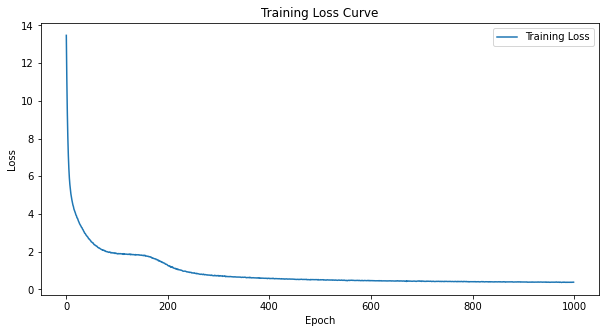

-------------------------Training Summary-------------------------
Mean Squared Error: 0.20823894441127777
-------------------------Training Summary-------------------------


In [15]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move data to the device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
print("input dim {}, output dim {}".format(input_dim, output_dim))
model = Net(input_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
losses = []
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test).item()
    print(f'Mean Squared Error: {mse}')

# Save the trained model
torch.save(model.state_dict(), cur_dir + '/model/' + 'OQMD_10k_model.pth')

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

print('-'*25 + 'Training Summary' + '-'*25)
print(f'Mean Squared Error: {mse}')
print('-'*25 + 'Training Summary' + '-'*25)


In [16]:
# model = Net()
# model.load_state_dict(torch.load(current_dir + '/model/' + 'OQMD_10k_model.pth'))

# # Make predictions
# model.eval()
# with torch.no_grad():
#     entry = CompositionEntry("Y2I6")
#     stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
#     ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
#     elemental = np.array(elemental_generator.generate_features([entry])).flatten()
#     # charge = np.array(charge_generator.generate_features([entry])).flatten()
    
#     # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
#     feature = np.concatenate([stoichiometric, ionicity, elemental])
#     feature = torch.tensor(feature, dtype=torch.float32)
#     prediction = model(feature)
#     print(prediction)

# # 'bandgap', 'energy_pa', 'volume_pa', 'magmom_pa', 'fermi', 'delta_e'

In [17]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = Net(input_dim, output_dim)
model.load_state_dict(torch.load(cur_dir + '/model/' + 'OQMD_10k_model.pth'))

def print_prediction(pred):
    print(f'Energy per atom: {pred[0][0]:.4f} eV')
    print(f'Formation energy per atom: {pred[0][1]:.4f} eV')
    print(f'Magnetization per atom: {pred[0][2]:.4f} Bohr magneton')

# Make predictions
model.eval()
with torch.no_grad():
    entry = CompositionEntry("Y2I6")
    stoichiometric = np.array(stoichiometric_generator.generate_features([entry])).flatten()
    ionicity = np.array(ionicity_generator.generate_features([entry])).flatten()
    elemental = np.array(elemental_generator.generate_features([entry])).flatten()
    # charge = np.array(charge_generator.generate_features([entry])).flatten()
    
    # feature = np.concatenate([stoichiometric, ionicity, elemental, charge])
    feature = np.concatenate([stoichiometric, ionicity, elemental])
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0)  # Add this line to fix the error
    prediction = model(feature)
    # print(prediction)
    print_prediction(prediction)

Energy per atom: -4.1042 eV
Formation energy per atom: -0.7195 eV
Magnetization per atom: 0.0923 Bohr magneton
